# Natural Language Processing Course Project
### Politecnico di Milano, A.Y. 2024/2025

This notebook has been created for the Natural Language Processing course, held by Prof. Carman.

**Authors**:
* Matteo Figini
* Riccardo Figini
* Samuele Forner
* Caterina Motti
* Simone Zacchetti

The purpose of this notebook is to apply different NLP techniques to analyse the **RecipeNLG** dataset, you can find the dataset at the following [link](https://huggingface.co/datasets/mbien/recipe_nlg).

In [ ]:
# Import useful libraries
import numpy as np
import pandas as pd
import os
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import random

# Preliminary analysis

In this section, we aim to perform a preliminary analysis of the dataset.
- Load and inspect the dataset: analyze which field are present, missing field or inconsistencies. 
- Analyze recipe distribution: compute statistics and visualize them.
- Analyze entities distribution: compute statistics and visualize them.

### Load and inspect the dataset

In [ ]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/recipenlg/dataset/full_dataset.csv")
df

In [ ]:
# Show the name of the columns
print("Columns:", df.columns.tolist())

Since the first column has no name, we renamed it:

In [ ]:
df = df.rename(columns={'Unnamed: 0': 'id'})

In [ ]:
# Dataset length
print(f"In the dataset there are {len(df)} different recipes!")

As we can see, the dataset contains 2231142 entries in 7 columns:
- id (int): ID.
- title (str): title of the recipe.
- ingredients (list of str): ingredients.
- directions (list of str): instruction steps.
- link (str): URL link.
- source (ClassLabel): origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    - "Gathered" (0): additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    - "Recipes1M" (1): recipes from the "Recipe1M+" dataset.
- NER (list of str): NER food entities.

Now, we check for **inconsistencies** and remove them if needed.

In [ ]:
# Rows with missing values
rows_with_null = df.isnull().any(axis=1).sum()
print(f"There are {rows_with_null} rows with at least one null value.")
print(df.isnull().sum())

The missing value is a title, which is not a critical field. However, we prefer to remove it.

In [ ]:
# Delete rows with at least one missing value
df.dropna()

In [ ]:
# Find duplicates by title
duplicate_counts = df['title'].value_counts()
print("Duplication results by: ", duplicate_counts)

Here we have lots of duplicates. However, they might represent different variations of the same recipe which could be useful for further analysis.

Since the dataset is really big (2M+ entries), we decided to make a random subsampling of it by retaining only 25% (around half million entries).

In [ ]:
# Randomly sample the dataset
df = df.sample(frac=0.25, random_state=42)

### Analyze vocaboulary

In [ ]:
# Import necessary libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams

# Download necessary NLTK data
nltk.download('stopwords')

In [ ]:
# Define a new column 'text' with directions as a string
df['text'] = df['directions'].apply(lambda x: ' '.join(ast.literal_eval(x)))
all_instructions_list = df['text'].tolist()

# Preprocess the text and tokenize it into words
full_text = ' '.join(all_instructions_list)
full_text = full_text.lower()
full_text = re.sub(r'[^a-zA-Z0-9\s]', '', full_text)
words = full_text.split()

# Remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
words_nostopwords = [w for w in words if w not in stop_words]
tokens = [w for w in words_nostopwords]

# Generate bigrams and frequency distribution
bigram_list = list(bigrams(tokens))
bigram_fdist = FreqDist(bigram_list)

# Frequency distribution of words
fdist = FreqDist(words_nostopwords)

In [ ]:
# Vocabulary size
vocabulary_size = len(fdist)
print("Vocabulary size: ", vocabulary_size)

# Average number of unique words per recipe
unique_words_per_recipe = []

for directions in df['text']:
    directions = directions.lower()
    directions = re.sub(r'[^a-zA-Z0-9\s]', '', directions)  # remove punctuation
    tokens = directions.split()  # split into words
    tokens = [w for w in tokens if w not in stop_words]
    unique_words = set(tokens)
    unique_words_per_recipe.append(len(unique_words))

avg_unique_words_per_recipe = sum(unique_words_per_recipe) / len(unique_words_per_recipe)    
print("Average number of unique words per recipe: ", avg_unique_words_per_recipe)

# Compute word length distribution
word_lengths = [len(word) for word in words_nostopwords]
avg_word_length = sum(word_lengths) / len(word_lengths)
min_word_length = min(word_lengths)
max_word_length = max(word_lengths)

print("Average word length: ", avg_word_length, " characters")
print("Minimum word length: ", min_word_length, " characters")
print("Maximum word length: ", max_word_length, " characters")

The high vocabulary size shows that the dataset is very rich and diverse, covering many ingredients, actions, and contextual descriptions. 

However the average number of unique words in each recipe is quite small: this suggests that each recipe tends to use a fairly concise and domain-specific subset.

NB: the maximum word length (262 characters) is likely an outlier. We must investigate it further. 

In [ ]:
# Find the longest words
def find_long_words_in_directions(df):
    long_words = []
    
    for directions in df['text']:
        # Extract words longer than 45 characters, since in English vocabulary the longest word has 45 characters
        long_words.extend([word for word in directions.split() if len(word) > 45])
    
    if long_words:
        print("Found ", len(long_words), " long words in the dataset (greater than 45 characters).")
        print("Printing the first 10 for brevity: \n")
        print(long_words[:10])
    else:
        print("No words longer than 45 characters found.")

find_long_words_in_directions(df)

Most of them are links, so we can keep them (also considering that they are not that frequent).

In [ ]:
# Create frequency distribution for bigrams
bigram_fdist = FreqDist(bigram_list)

# Display top 10 most common words
print("\nTop 10 most common words:")
for word, freq in fdist.most_common(10):
    print(f"{word}: {freq}")

# Display top 10 most common bigrams
print("\nTop 10 most common bigrams:")
for bigram, freq in bigram_fdist.most_common(10):
    print(f"{' '.join(bigram)}: {freq}")


### Analyze recipes distribution
Since the recipes are the core of the dataset, it may be useful to analyse the length of each recipe to plot their distribution.

Recipes with very high or very low word counts might be outliers. Analyzing the distribution allows us to detect these outliers, which might skew our analysis. For instance, a recipe with only one word might be a mistake.

In [ ]:
# Define a new column to count the number of words in 'directions'
df['dir_word_count'] = df['directions'].apply(lambda x: len(' '.join(x).split()))

In [ ]:
# Retrieve the length and index of the longest and shortest recipe
max_words = df['dir_word_count'].max()
min_words = df['dir_word_count'].min()

max_words_idx = df['dir_word_count'].idxmax()
min_words_idx = df['dir_word_count'].idxmin()
print(f"Recipes' direction have between {min_words} and {max_words} words.")
print(f"The longest recipe has {max_words} words and it stands at location {max_words_idx}.")
#print(df['directions'].loc[max_words_idx])
print(df[['title','directions', 'dir_word_count']].loc[min_words_idx])

In [ ]:
# Visualize the distribution of the number of words in column "directions" to show how long recipes are (in number of words)
plt.figure(figsize=(12,6))
plt.hist(df['dir_word_count'], bins=max_words, range=(0, max_words))
plt.title('Distribution of words in column \"directions\"')
plt.xlabel('Number of words in the recipe')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [ ]:
# Analyzing recipe word count distribution
word_counts = df['dir_word_count'].dropna()
mean_word_count = word_counts.mean()
median_word_count = word_counts.median()
percentile_90 = word_counts.quantile(0.9)
percentile_95 = word_counts.quantile(0.95)

print(f"Mean word count: {mean_word_count}")
print(f"Median word count: {median_word_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

In [ ]:
# Count recipes with less than upper_threshold words
upper_threshold = 300
count_less_threshold = (word_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} words.")

In [ ]:
# Count recipes with more than lower_threshold words
lower_threshold = 20
count_more_threshold = (word_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} words.")

### Analyze entities distribution
The aim of this section is to analyse the number of elements in the NER column, which contains the number of entities in each recipe, and to provide a distribution, giving a rough measure of the "complexity" of the recipe.

In [ ]:
# Define a new column containing the number of entities of each recipe
ner_column = 'ner_len'
df[ner_column] = df['NER'].apply(lambda x: len(ast.literal_eval(x)))

In [ ]:
# Retrieve the length and index of recipe with highest and lowest NER number
max_ner_len = df[ner_column].max()
min_ner_len = df[ner_column].min()

max_ner_len_idx = df[ner_column].idxmax()
print(f"Recipes have between {min_ner_len} and {max_ner_len} entities.")

print(f"The 'biggest' recipe has {max_ner_len} entities and it is at location {max_ner_len_idx}.")
#print(df['NER'].loc[max_ner_len_idx])

In [ ]:
# Visualize the number of entities in each recipe
plt.figure(figsize=(12,6))
plt.hist(df[ner_column], bins=max_ner_len, range=(0, max_ner_len))
plt.title('Distribution of the number of entities')
plt.xlabel('Number of entities')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [ ]:
# Analyzing recipe NER count distribution
entities_counts = df[ner_column].dropna()
mean_entities_count = entities_counts.mean()
median_entities_count = entities_counts.median()
percentile_90 = entities_counts.quantile(0.9)
percentile_95 = entities_counts.quantile(0.95)

print(f"Mean NER count: {mean_entities_count}")
print(f"Median NER count: {median_entities_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

In [ ]:
# Count recipes with less than upper_threshold entities
upper_threshold = 25
count_less_threshold = (entities_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} entities.")

In [ ]:
# Count recipes with more than lower_threshold entities
lower_threshold = 3
count_more_threshold = (entities_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} entities.")

In [ ]:
# Filter recipes where there are NO NER
zero_NER_recipes = df[df['ner_len'] == 0]

print(zero_NER_recipes[['title', 'NER']])
# Drop recipes where there are no NERs
df = df[df['ner_len'] != 0]

It means that the NER process didn't detect any entities for these recipes. This could happen for various reasons, such as:
- The recipe doesn't contain recognizable entities like ingredients, amounts, or special terms.
- The NER process might not be comprehensive enough to detect all relevant entities in the recipe.
- The recipe could be incomplete or malformed in a way that prevents proper entity recognition.

For this reason, we decided to drop these rows.

NB: It may happens that there are NO entries without NER, since we are using a subsample of the original dataset. 

## Clustering

Now we want to perform some clustering analysis.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
titles = df['title'].astype(str)
X = vectorizer.fit_transform(titles)

In [ ]:
inertia = []
k_values = list(range(2, 50))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow method to determine k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Intertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

It seems that two interesting values for K are 13 and 21, let's try both of them.

In [ ]:
n_clusters = 13
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

# Add clusters to the original dataframe
df['cluster'] = kmeans.labels_

# Print an example of titles grouped by cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))

In [ ]:
# la eliminiamo?
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[titles.iloc[j] for j in sorted_terms[:10]]

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

In [ ]:
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

In [ ]:
n_clusters = 21
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

df['cluster'] = kmeans.labels_

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))

In [ ]:
# la rimuoviamo?
centroid = kmeans.cluster_centers_[0]

sorted_terms = centroid.argsort()[::-1]

[titles.iloc[j] for j in sorted_terms[:20]]

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

In [ ]:
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

### Evaluation

In order to evaluate our clustering we are using only intrinsic method, since we do not have the real labels of the clusters.

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(X, kmeans.labels_)))

Since the dataset is quite big, even reducing it to a quarter of the original, we try to perform also a Mini Batch Clustering.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 21
mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters,batch_size=500, random_state=2307)
mb_kmeans.fit(X)

In [ ]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(mb_kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(X, mb_kmeans.labels_)))

Now, let's try to visualize clusters.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(X)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.')

We have also tried to perform clustering for the NER column, performing the 'elbow method' and plotting the results. However, the plot has not highlighter any points in which improvement in the measure decreases substantially from one time step to the next. 

## Indexing
We decided to index the recipes based on the directions, in order to perform keyword search over them. We choose the directions since they will likely contains both ingredients and keywords relative to the procedure (e.g. baked, fried).

In [ ]:
!pip install -q python-terrier==0.11.0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pyterrier as pt

if not pt.started():
  pt.init()

In [ ]:
# Create a list of documents (use 'title' for indexing)
documents_title = [{'docno': str(i), 'text': text} for i, text in enumerate(df['title'])]

# Create the index
indexer = pt.IterDictIndexer("./index_title")
indexer.index(documents_title)

In [ ]:
# Create a list of documents (use 'directions' for indexing)
documents_directions = [{'docno': str(i), 'text': text} for i, text in enumerate(df['directions'])]

# Create the index
indexer = pt.IterDictIndexer("./index_directions")
indexer.index(documents_directions)

In [ ]:
# Create documents with multiple fields
documents_fields = [
    {
        'docno': str(i),
        'title': row['title'],
        'ingredients': row['ingredients'],
        'directions': row['directions']
    }
    for i, row in df.iterrows()
]

# Index the fielded documents
indexer_fields = pt.IterDictIndexer("./index_fields")

# Set meta fields and indexed fields
indexref = indexer_fields.index(
    documents_fields,
    fields=["title", "ingredients", "directions"],  
    meta={'docno': 20, 'title': 512, 'ingredients': 1024, 'directions': 4096}
)

In [ ]:
# Create a searcher using the index
index_title = pt.IndexFactory.of("./index_title")
index_directions = pt.IndexFactory.of("./index_directions")
index_fields = pt.IndexFactory.of(indexref)

# BM25 retrieval model
bm25_tit = pt.terrier.Retriever(index_title, wmodel="BM25")
bm25_dir = pt.terrier.Retriever(index_directions, wmodel="BM25")

# TF-IDF retrieval model
tfidf_tit = pt.terrier.Retriever(index_title, wmodel="TF_IDF")
tfidf_dir = pt.terrier.Retriever(index_directions, wmodel="TF_IDF")

# DFRee retrieval model (Document Frequency based)
dfree_tit = pt.terrier.Retriever(index_title, wmodel="DFRee")
dfree_dir = pt.terrier.Retriever(index_directions, wmodel="DFRee")

# Create BM25F retriever with field weights
# Weighted BM25 over each field
bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")

# Weighted combination of scores: BM25F-like
bm25f_manual = (
    bm25_title * 0.3 +
    bm25_ingredients * 0.4 +
    bm25_directions * 0.3
)

By using all of these models, we can perform a comprehensive evaluation of the different retrieval strategies. Each model captures different aspects of relevance:

- BM25 accounts for both term and document frequencies, providing a balanced relevance score.
- TF-IDF emphasizes the importance of rare terms across the document collection.
- DFRee is useful for understanding how document frequency affects relevance.

We also tried BM25 without term frequency (no tf), but it performed to same as classic BM25. This is likely because in our dataset, document length and term frequency did not vary significantly across relevant documents, so removing the tf component had minimal impact on ranking.
To keep the notebook clean we omitted this variant.

In [ ]:
print(index_title.getCollectionStatistics().toString())
print(index_directions.getCollectionStatistics().toString())
print(index_fields.getCollectionStatistics().toString())

In [ ]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models for the titles including BM25F
    result_bm25_tit = bm25_tit.search(q['query'])
    result_tfidf_tit = tfidf_tit.search(q['query'])
    result_dfree_tit = dfree_tit.search(q['query'])   

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25_tit),
        ("TF-IDF", result_tfidf_tit),
        ("DFRee", result_dfree_tit),
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, (docno, score) in enumerate(zip(result["docno"][:5], result["score"][:5])):
            docno_int = int(docno)  # Convert from str to int
            title = df['title'].iloc[docno_int] if docno_int < len(df) else "TITLE NOT FOUND"
            print(f"DocNO: {docno:<7} | Title: {title:<50.48} | Score: {score:.4f}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title,
                'Score': score
            })

In [ ]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

In this case, BM25 and TF-IDF yielded the same document rankings: this happen when documents are short, uniformly sized, or when term frequencies are relatively balanced, making the additional complexity of BM25 less impactful.

This suggest that relying only on document titles for indexing provides limited term variability and context, reducing the effectiveness of retrieval models. Incorporating richer textual content would likely yield more discriminative and informative rankings.

In [ ]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models for the directions including BM25F
    result_bm25_dir = bm25_dir.search(q['query'])
    result_tfidf_dir = tfidf_dir.search(q['query'])
    result_dfree_dir = dfree_dir.search(q['query'])
    
    result_bm25f = bm25f_manual.search(q['query'])  

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25_dir),
        ("TF-IDF", result_tfidf_dir),
        ("DFRee", result_dfree_dir),
        ("BM25F", result_bm25f) 
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, (docno, score) in enumerate(zip(result["docno"][:5], result["score"][:5])):
            docno_int = int(docno)  # Convert from str to int
            title = df['title'].iloc[docno_int] if docno_int < len(df) else "TITLE NOT FOUND"
            print(f"DocNO: {docno:<7} | Title: {title:<50.48} | Score: {score:.4f}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title,
                'Score': score
            })

In [ ]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

About the results:

- TF-IDF put “Balsamic Glazed Salmon” at #1: we can see that TF-IDF’s emphasis on rare terms may be boosting “balsamic”.
- DFRee puts “Fennel-And-Dill-Rubbed Grilled Salmon” at #1, and then “Salmon Wrapped In Fig Leaves With Baked Kale” at #2: it shows that rarer, longer titles win more weight under DFRee.
- Unlike single-field models, BM25F combines weighted evidence from different parts of the document, making it robust when key terms appear in both title, ingredients and directions.

## Word2Vec

Training a Word2Vec embedding on the RecipeNLG dataset allows us to capture the semantic relationships between words in cooking instructions. Word2Vec learns to represent words as dense vectors, where words with similar meanings are positioned closer together in the vector space. This enables us to explore word similarities, identify common patterns, and improve various natural language processing tasks like recipe recommendation and ingredient analysis.

In [ ]:
# Convert the 'text' column of the DataFrame into a list of strings (e.g., recipe directions)
w2v_directions = list(df['text'])

# Tokenize each direction 
tokenized_directions = [re.sub('\W', ' ', direction).lower().split() for direction in w2v_directions]

Let's remove the stopwords
(we need a context window to train it, so we are discarding the directions composed by only one word)

In [ ]:
filtered_directions = [[word for word in sublist if word not in stop_words] for sublist in tokenized_directions]
filtered_directions = [direction for direction in filtered_directions if len(direction) > 1]
len(filtered_directions)

Now it's time to  train our model!


In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(filtered_directions, vector_size=50, min_count=5, window=10)

len(model.wv)

Ever wondered what is a possible vector representation of the word soup?  Me neither!

In [ ]:
term = 'soup'
model.wv[term]

Or what are the most similar words to 'chicken' (Between the ones in our dataset)

In [ ]:
term = 'chicken'
model.wv.most_similar(term)

From 0 to 1, how  similar the words chicken and beef are?

In [ ]:
model.wv.similarity('chicken', 'beef')

chicken:breast = beef:?

In [ ]:
vec = model.wv['beef'] + model.wv['breast'] - model.wv['chicken']
model.wv.similar_by_vector(vec)

Right now we are working with embedding vectors of 50 dimensions. Unfortunately, the human brain is limited and can visualize only up to three of them. So it's necessary to reduce our vectors' dimensions to this number. Let's try to do so using t-distributed stochastic neighbor embedding (t-SNE):

In [ ]:
from sklearn.manifold import TSNE

samples = random.sample(list(model.wv.key_to_index), 1000)
vectors = model.wv[samples]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(vectors)

x, y, z = np.transpose(tsne_embedding)

In [ ]:
import plotly.express as px

fig = px.scatter_3d(x=x[:300],y=y[:300],z=z[:300],text=samples[:300])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Quite interesting isn't it? 

Numbers are near each other (probably they represent different oven temperatures). Also values like 9x5x3 and 2x3 (lengths of the baking trays?).

Same for fruits and vegetables

Why don't we try principal component analysis to perform the dimensionality reduction?

(and also sample again, you never know)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
samples = random.sample(list(model.wv.key_to_index), 1000)
vectors = model.wv[samples]

pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(vectors)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}" )
print(f"Total explained variance: {sum(explained_variance_ratio)}")

In [ ]:
x, y, z = np.transpose(pca_embedding)

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=samples[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

The 3 dimensions that hold the most informations tent to agglomerate around the values (0,0,0), making pca reductions not suited for visualisation purposes


# Training models

In this section we are going to train some models, from the easiest to the most complex ones.

Firstly, we create a secreto token to use HuggingFace models.

In [ ]:
⁠from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("NLP project") ⁠


# Further developments

We would like to see how some of our riceipts can look like...

In [ ]:
# Extract 3 titles to turn into images
sampled_titles = df['title'].sample(n=3, random_state=42).tolist()

In [ ]:
import torch
from huggingface_hub import login

login(secret_value_0)

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, title in enumerate(sampled_titles):
    image = pipe(prompt=title).images[0]
    axes[i].imshow(image)
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

In [ ]:
plt.tight_layout()
plt.show()

## Multi agent system using Pretrained llm

#### Introduction

This code implements a multi-agent system for generating and refining cooking recipes using a pretrained LLM (GPT-4) and information retrieval techniques. It leverages PyTerrier for indexing and retrieving recipes based on ingredients and directions. The system allows dynamic interactions with the user, enabling recipe generation, modification, and regeneration based on feedback. Using LangChain and LangGraph, the system orchestrates a workflow of nodes for handling user input, generating recipes, and refining them based on real-time corrections. The approach integrates both tools and prompts to create a flexible, user-driven cooking assistant.

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Get the values from the environment variables
java_home = os.getenv("JAVA_HOME")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Print the values to check
print(f"JAVA_HOME: {java_home}")
print(f"OPENAI_API_KEY: {openai_api_key}")


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
import pyterrier as pt  
import json

from langchain_core.messages import HumanMessage
from typing import Any
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
if not pt.started():
    pt.init()

C:\Users\figio\AppData\Local\Temp\ipykernel_7080\3057724015.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():
Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
C:\Users\figio\AppData\Local\Temp\ipykernel_7080\3057724015.py:2: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


#### Graph objecs

In [ ]:
"""
I am using the ChatOpenAI model from LangChain, which is a wrapper around OpenAI's GPT-3.5 and GPT-4 models.
"""
llm = ChatOpenAI(model="gpt-4", temperature=0.7)

In [ ]:
"""
State Graph, maintaining the state of the conversation.
"""
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#### RAG

In [ ]:
# Percorso assoluto all'indice
index_path = r"C:\\Users\\figio\\Desktop\\cooking-mama\\Riccardo Finigi\\index_fields"

# Verifica se l'indice esiste già
if os.path.exists(index_path) and os.path.exists(os.path.join(index_path, "data.properties")):
    print("✔️ Index already exists. Using existing index.")
    indexref = index_path
else:
    print("🛠️ Index not found. Building new index...")

    documents_fields = [
        {
            'docno': str(row['id']),  # usa l'id reale
            'title': row['title'],
            'ingredients': row['ingredients'],
        }
        for _, row in df.iterrows()
    ]

    os.makedirs(index_path, exist_ok=True)

    indexer_fields = pt.IterDictIndexer(index_path)
    indexref = indexer_fields.index(
        documents_fields,
        fields=["title", "ingredients"],
        meta={'docno': 20, 'title': 512, 'ingredients': 1024}
    )

# Costruisci oggetto Index e motore di retrieval
index_fields = pt.IndexFactory.of(indexref)
bm25_ingredients = pt.terrier.Retriever(
    index_fields,
    wmodel="BM25",
    controls={"w": "1.0"},
    metadata=["docno", "ingredients"],
    field="ingredients"
)



✔️ Index already exists. Using existing index.
13:10:32.783 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


In [ ]:
index_path_directions = r"C:\\Users\\figio\\Desktop\\cooking-mama\\Riccardo Finigi\\index_directions"


if os.path.exists(index_path_directions) and os.path.exists(os.path.join(index_path_directions, "data.properties")):
    print("✔️ Index already exists. Using existing index.")
    indexref_2 = index_path_directions
else:
    print("🛠️ Index not found. Building new index fir directions...")
    
    documents_fields = [
        {
            'docno': str(row['id']),  # usa l'id reale
            'title': row['title'],
            'directions': row['directions'],
        }
        for _, row in df.iterrows()
    ]

    os.makedirs(index_path_directions, exist_ok=True)

    indexer_fields = pt.IterDictIndexer(index_path_directions)
    indexref_2 = indexer_fields.index(
        documents_fields,
        fields=["title", "directions"],
        meta={'docno': 20, 'title': 512, 'directions': 4096}
    )
    

# Costruisci oggetto Index e motore di retrieval
index_fields = pt.IndexFactory.of(indexref_2)
bm25_directions = pt.terrier.Retriever(
    index_fields,
    wmodel="BM25",
    controls={"w": "1.0"},
    metadata=["docno", "directions"],
    field="directions"
)

✔️ Index already exists. Using existing index.
13:10:33.408 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


#### Prompts

Here, a series of prompts are described for querying the LLM to perform various tasks. The prompts range from recipe generation to recipe validation, and they all follow a predefined format for how the app should respond, allowing for the use of a parser. The first two prompts also provide the ability to input custom information.

In [ ]:
prompt_system_ingrs = """
You are a creative and helpful cooking assistant.

The user will provide a list of available ingredients.  
Your task is to create a complete and realistic recipe using **only those ingredients** — do not invent or add anything not included in the list.

The recipe must include:
- A clear and descriptive title
- Step-by-step preparation instructions

Important rules:
- Do NOT use any ingredient that is not listed.
- If a necessary item (e.g., salt, oil, water) is missing, do NOT assume it's available — exclude it.
- You can adjust the form or quantity of the ingredients (e.g., chop, grate, blend), but not add new ones.
- If the ingredients are unusual together, invent a plausible or creative dish that still makes good use of them.

Output your response in the following JSON format:

{{
	"title": string  // The title of the recipe
	"list_of_steps": string  // A list of steps to prepare the dish, only the list
}}

DO NOT return any other text or explanation, just the JSON.

Example, take some ispiration from this:
{Example}

"""

In [ ]:
response_schemas_2 = [
    ResponseSchema(
        name='title',
        description='The title of the recipe',
    ),
    ResponseSchema(
        name='list_of_steps',
        description='A list of steps to prepare the dish, only the list',
    )
]

In [ ]:
output_parser_2 = StructuredOutputParser.from_response_schemas(response_schemas_2)

In [ ]:
prompt_system_ingrs_ = ChatPromptTemplate.from_messages(
    [('system', prompt_system_ingrs), ('user', '{messages}')]
).partial(format_instructions=output_parser_2.get_format_instructions())

In [ ]:
prompts_rigeneration_ask = """
You are a cooking expert, and your task is to improve the recipe. The recipe has already been generated and is visible in the message list. 
Your job is to determine whether additional information is needed from a tool to improve the recipe, or if you should proceed with a new generation using the user's corrections. 

Your task is to decide whether to use a tool or not. There are two possible tools available:
- `retrieve_by_ingredients_tool`: a tool that retrieves recipes based on the ingredients provided by the user.
- `retrieve_by_directions_tool`: a tool that retrieves recipes based on the directions provided for preparing the dish.

Make a reasoning about the recipe and the information you have, and what is necessary to improve it.
Than call always the tool, even if you don't need it, to increase the information in the recipe.

This is the list of changes that the user has made to the recipe:
{corrections}

That are very important to take into account in the new generation.

"""

In [ ]:
prompts_rigeneration_ = ChatPromptTemplate.from_messages(
    [('system', prompts_rigeneration_ask), ('user', '{messages}')]
)

In [ ]:
prompt_regen = """
You are a creative and helpful cooking assistant.

The user will provide a list of message.  Use the messages to retrieve all the information that is needed to regenerate the recipe, because this is a regeneration following new directions.
Your task is to create a complete and realistic recipe using **only those ingredients** — do not invent or add anything not included in the list.

The recipe must include:
- A clear and descriptive title
- Step-by-step preparation instructions

Important rules:
- Do NOT use any ingredient that is not listed.
- If a necessary item (e.g., salt, oil, water) is missing, do NOT assume it's available — exclude it.
- You can adjust the form or quantity of the ingredients (e.g., chop, grate, blend), but not add new ones.
- If the ingredients are unusual together, invent a plausible or creative dish that still makes good use of them.

Output your response in the following JSON format:

{{
	"title": string  // The title of the recipe
	"list_of_steps": string  // A list of steps to prepare the dish, only the list
}}

"""

In [ ]:
prompt_regen_ = ChatPromptTemplate.from_messages(
    [('system', prompt_regen), ('user', '{messages}')]
).partial(format_instructions=output_parser_2.get_format_instructions())

#### Tool

The tools are resources that agents can utilize to perform operations that generally do not involve LLMs but are local and independent of them. In this case, specifically, the tools are related to RAG (Retrieval-Augmented Generation), meaning they are used for retrieving existing recipes to gather insights or inspiration. These tools allow the system to pull relevant data without relying on the LLM, improving the recipe generation process by leveraging previously indexed information.

In [ ]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    1. This creates a node in a LangGraph that can execute a list of tools (which are functions, APIs, or other callable objects).
    2. With_fallbacksensuring: if an error occurs, the agent receives a structured error message instead of failing.This adds a fallback mechanism in case any tool in tools fails.
    3. Wraps the handle_tool_error function inside a RunnableLambda, making it compatible with LangGraph's execution model.

    I nodi che utilizzano "funzioni esterne" sono visti come uno o più tools. Questi tool sono chiamati in successione poi
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [ ]:
@tool
def retrive_by_ingredients(ingredients: str):
    """Retrieves a recipe based on the provided ingredients."""
    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(ingredients)
    if result.empty:
        return "No recipes found."
    
    id = result.iloc[0]["docno"]
    id = int(id)  # converti in intero

    return df[df["id"] == id]

In [ ]:
@tool
def retrieve_by_ingredients_tool(ingredients: str, num_recipes: int):
    """
    Retrieves a specified number of recipes based on the provided ingredients.

    Parameters:
    - ingredients (str): A string representing the ingredients to search for in the recipes.
      Ingredients should be separated by a comma and a space (e.g., "chicken, garlic, pasta").
    - num_recipes (int): The number of recipes to be returned as search results.
      This parameter defines how many recipes are returned. It can be any positive integer.

    Returns:
    - List[DataFrame]: A list of DataFrames, each representing a recipe. Each DataFrame contains
      the details of a recipe that matches the provided ingredients.
      If there are fewer recipes than requested, the function will return only those found.
      If no recipes are found, a message saying "No recipes found." will be returned.

    """

    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(ingredients)
    if result.empty:
        return "No recipes found."

    # Prepara una lista di ricette
    recipes = []
    
    # Itera attraverso i risultati trovati, limitato al numero richiesto di ricette
    for idx in result.index[:num_recipes]:  # Prendi solo le prime N ricette
        recipe_id = int(result.loc[idx, "docno"])  # Converte l'id in intero
        recipe = df[df["id"] == recipe_id]
        recipes.append(recipe)
    # Restituisce la lista delle ricette trovate (può essere meno di N se non ci sono abbastanza risultati)
    return recipes


In [ ]:
@tool
def retrieve_by_directions_tool(directions: str, num_recipes: int):
    """
    Retrieves a specified number of recipes based on the provided directions.

    Parameters:
    - directions (str): A string representing the directions to search for in the recipes.
    - num_recipes (int): The number of recipes to be returned as search results.
      This parameter defines how many recipes are returned. It can be any positive integer.

    Returns:
    - List[DataFrame]: A list of DataFrames, each representing a recipe. Each DataFrame contains
      the details of a recipe that matches the provided ingredients.
      If there are fewer recipes than requested, the function will return only those found.
      If no recipes are found, a message saying "No recipes found." will be returned.

    """

    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(directions)
    
    if result.empty:
        return "No recipes found."

    # Prepara una lista di ricette
    recipes = []
    
    # Itera attraverso i risultati trovati, limitato al numero richiesto di ricette
    for idx in result.index[:num_recipes]:  # Prendi solo le prime N ricette
        recipe_id = int(result.loc[idx, "docno"])  # Converte l'id in intero
        recipe = df[df["id"] == recipe_id]
        recipes.append(recipe)

    # Restituisce la lista delle ricette trovate (può essere meno di N se non ci sono abbastanza risultati)
    return recipes


#### Chain

The chains are sequences of operations that need to be executed when interacting with the LLM. They typically involve preparing the prompt, setting up the LLM, and handling the response. In some cases, chains also include calling the tools.

In [ ]:
recipe_chain_2 = prompt_system_ingrs_ | llm | output_parser_2

In [ ]:
regen_chain = prompts_rigeneration_ | llm.bind_tools(
    [retrieve_by_ingredients_tool, retrieve_by_directions_tool],
    tool_choice="required"
) 

In [ ]:
recipe_regen = prompt_regen_ | llm | output_parser_2

#### Node

In [ ]:
def starter(state: State) -> dict[str, list[AIMessage]]:
    """
    This node initializes the workflow by collecting a list of ingredients 
    from the user and creating a HumanMessage with the input.
    """
    user_input = input("Enter a list of ingredients (comma-separated): ")
    return {"messages": HumanMessage(content=user_input)}

In [ ]:
def first_generation(state: State) -> dict[str, list[AIMessage]]:
    """
    This function generates a recipe based on the ingredients provided by the user.
    
    Steps:
    1. Extracts the list of ingredients from the last message in the state.
    2. Uses the `retrive_by_ingredients` tool to retrieve a recipe matching the ingredients.
    3. Passes the retrieved recipe and messages to the `recipe_chain_2` for further processing.
    4. Prints the recipe title and preparation steps.
    5. Returns the updated state with the generated recipe.

    """
    ingredients = state["messages"][-1].content

    recipe = retrive_by_ingredients(ingredients)

    response_2 = recipe_chain_2.invoke({"messages": state["messages"], "Example": recipe})

    print("\n\n\n\nTitle:", response_2['title'])

    print("\nPreparation Steps:")
    for i, step in enumerate(response_2['list_of_steps'], 1):
        print(f"{i}. {step}")

    return {"messages": AIMessage(content=json.dumps(response_2, indent=2))}
    

In [ ]:
def modify_generation(state: State) -> dict[str, list[AIMessage]]:
    """
    This function regenerates a recipe based on the user's input and the current state.
    Use the lit of messages to retrieve all the information needed to regenerate the recipe.
    It checks if the user wants to use a tool to improve the recipe or if it should proceed with a new generation.

    Steps:
    1. Invokes the `recipe_regen` chain using the messages from the current state.
    2. Extracts the title and preparation steps from the response.
    3. Prints the recipe title and step-by-step preparation instructions.
    4. Returns the updated state with the newly generated recipe.

    """
    response_2 = recipe_regen.invoke({"messages": state["messages"]})

    print("\n\n\n\nTitle:", response_2['title'])

    print("\nPreparation Steps:")
    for i, step in enumerate(response_2['list_of_steps'], 1):
        print(f"{i}. {step}")

    return {"messages": AIMessage(content=json.dumps(response_2, indent=2))}


In [ ]:
def ask_what_to_do(state: State) -> dict[str, list[AIMessage]]:
    """
    This node interacts the LLM that decides what to do whether to retrieve other recipes by ingredients or by instructions, 
    or simply go to regenerate with the new directions.
    """
    user_input = input("What do you want to do?")

    response_2 = regen_chain.invoke({"messages": state["messages"], "corrections": user_input})
    print(response_2)
    return {"messages": [response_2]}

In [ ]:
def modify_recipe_condition(state: State) -> Literal[END, "ask_what_to_do"]:
    """
    This function determines whether the user wants to modify the recipe or terminate the program.
    It prompts the user for input and checks if they want to make changes or end the program.
    """
    print("\n\nModifying recipe...Do you need to change something?")
    user_input = input("Enter NO or YES: ")
    if user_input.lower() == "no":
        return END
    else:
        return "ask_what_to_do"

In [ ]:
def where_continue(state: State) -> Literal["modify_generation", "retrieve_by_ingredients_tool", "retrieve_by_directions_tool"]:
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        for tc in last_message.tool_calls:
            if tc["name"] == "retrieve_by_ingredients_tool":
                return "retrieve_by_ingredients_tool"
            elif tc["name"] == "retrieve_by_directions_tool":
                return "retrieve_by_directions_tool"
    else:
        return "modify_generation"

In [ ]:
workflow = StateGraph(State)

workflow.add_node("starter", starter)

workflow.add_node("first_generation", first_generation)

workflow.add_node("ask_what_to_do", ask_what_to_do)

workflow.add_node("modify_generation", modify_generation)

workflow.add_node("retrieve_by_ingredients_tool", create_tool_node_with_fallback([retrieve_by_ingredients_tool]))

workflow.add_node("retrieve_by_directions_tool", create_tool_node_with_fallback([retrieve_by_directions_tool]))

#_____________________________________________________________________________________________________________#

workflow.add_edge(START, "starter")

workflow.add_edge("starter", "first_generation")

workflow.add_conditional_edges(
    "first_generation",
    modify_recipe_condition
)

workflow.add_conditional_edges(
    "ask_what_to_do",
    where_continue
)

workflow.add_edge("retrieve_by_ingredients_tool", "modify_generation")

workflow.add_edge("retrieve_by_directions_tool", "modify_generation")

workflow.add_conditional_edges(
    "modify_generation",
    modify_recipe_condition
)

app = workflow.compile()

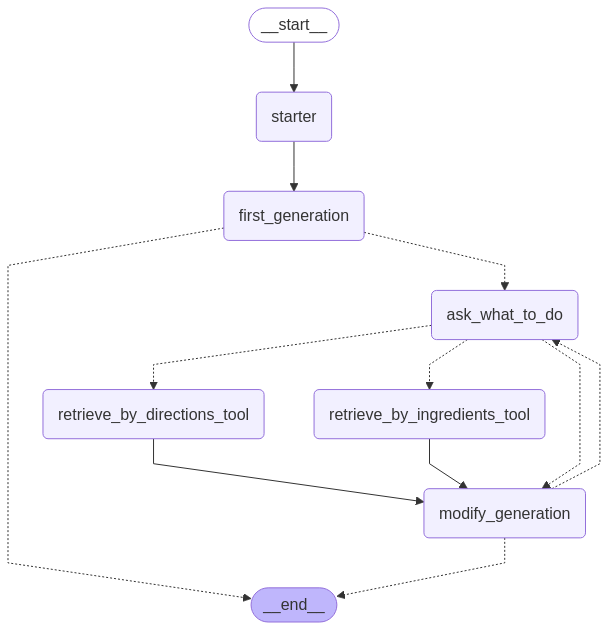

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
initial_state = {
                'messages': []
}

app.invoke(initial_state)

C:\Users\figio\AppData\Local\Temp\ipykernel_7080\202224046.py:15: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  recipe = retrive_by_ingredients(ingredients)
TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00,  2.57q/s]






Title: Simple Chicken and Potato Fry

Preparation Steps:
1. 1. Clean and cut the chicken into small pieces.
2. 2. Wash the potatoes thoroughly and cut them into small cubes.
3. 3. Heat the oil in a pan over medium heat.
4. 4. Add the chicken pieces to the pan and fry until they turn golden brown.
5. 5. Remove the chicken from the pan and set aside.
6. 6. In the same pan, add the potato cubes and fry until they turn golden brown and crispy.
7. 7. Add the fried chicken back to the pan and mix well with the potatoes.
8. 8. Fry the mixture for another few minutes until everything is well combined.
9. 9. Remove from the heat and serve hot.


Modifying recipe...Do you need to change something?
content='' additional_kwargs={'tool_calls': [{'id': 'call_sz58pm9SwBGfPwZmvFlmk3tB', 'function': {'arguments': '{\n  "ingredients": "chicken, oil, potatos, tomatos",\n  "num_recipes": 5\n}', 'name': 'retrieve_by_ingredients_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_us

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00, 13.59q/s]






Title: Fried Chicken and Potatoes with Tomato Mix

Preparation Steps:
1. 1. Clean and cut the chicken into small pieces.
2. 2. Wash the potatoes thoroughly and cut them into small cubes.
3. 3. Heat the oil in a pan over medium heat.
4. 4. Add the chicken pieces to the pan and fry until they turn golden brown.
5. 5. Remove the chicken from the pan and set aside.
6. 6. In the same pan, add the potato cubes and fry until they turn golden brown and crispy.
7. 7. While the potatoes are cooking, wash the tomatoes and cut them into small pieces.
8. 8. Add the tomatoes to the pan with the potatoes and cook until they are softened.
9. 9. Add the fried chicken back to the pan and mix well with the potatoes and tomatoes.
10. 10. Fry the mixture for another few minutes until everything is well combined.
11. 11. Remove from the heat and serve hot.


Modifying recipe...Do you need to change something?


{'messages': [HumanMessage(content='chicken oil potatos', additional_kwargs={}, response_metadata={}, id='f9611e0d-4115-41ae-8359-3fe81de34a47'),
  AIMessage(content='{\n  "title": "Simple Chicken and Potato Fry",\n  "list_of_steps": [\n    "1. Clean and cut the chicken into small pieces.",\n    "2. Wash the potatoes thoroughly and cut them into small cubes.",\n    "3. Heat the oil in a pan over medium heat.",\n    "4. Add the chicken pieces to the pan and fry until they turn golden brown.",\n    "5. Remove the chicken from the pan and set aside.",\n    "6. In the same pan, add the potato cubes and fry until they turn golden brown and crispy.",\n    "7. Add the fried chicken back to the pan and mix well with the potatoes.",\n    "8. Fry the mixture for another few minutes until everything is well combined.",\n    "9. Remove from the heat and serve hot."\n  ]\n}', additional_kwargs={}, response_metadata={}, id='a655db04-bc7c-4496-aee5-4c352468bfdd'),
  AIMessage(content='', additional_k